# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
import copy
from omegaconf import OmegaConf, open_dict
import numpy as np
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "mixup"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 8
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

    cfg.attack.optim.max_iterations = 24000
    
    cfg.seed = 233

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of       9:1 for target shape [8, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 8

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
 

In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 8

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: soft
        step_size: 0.1
        boxed: True
        max_iterations: 24000
        step_size_dec

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 8
how_many_rec = 8

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [7]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

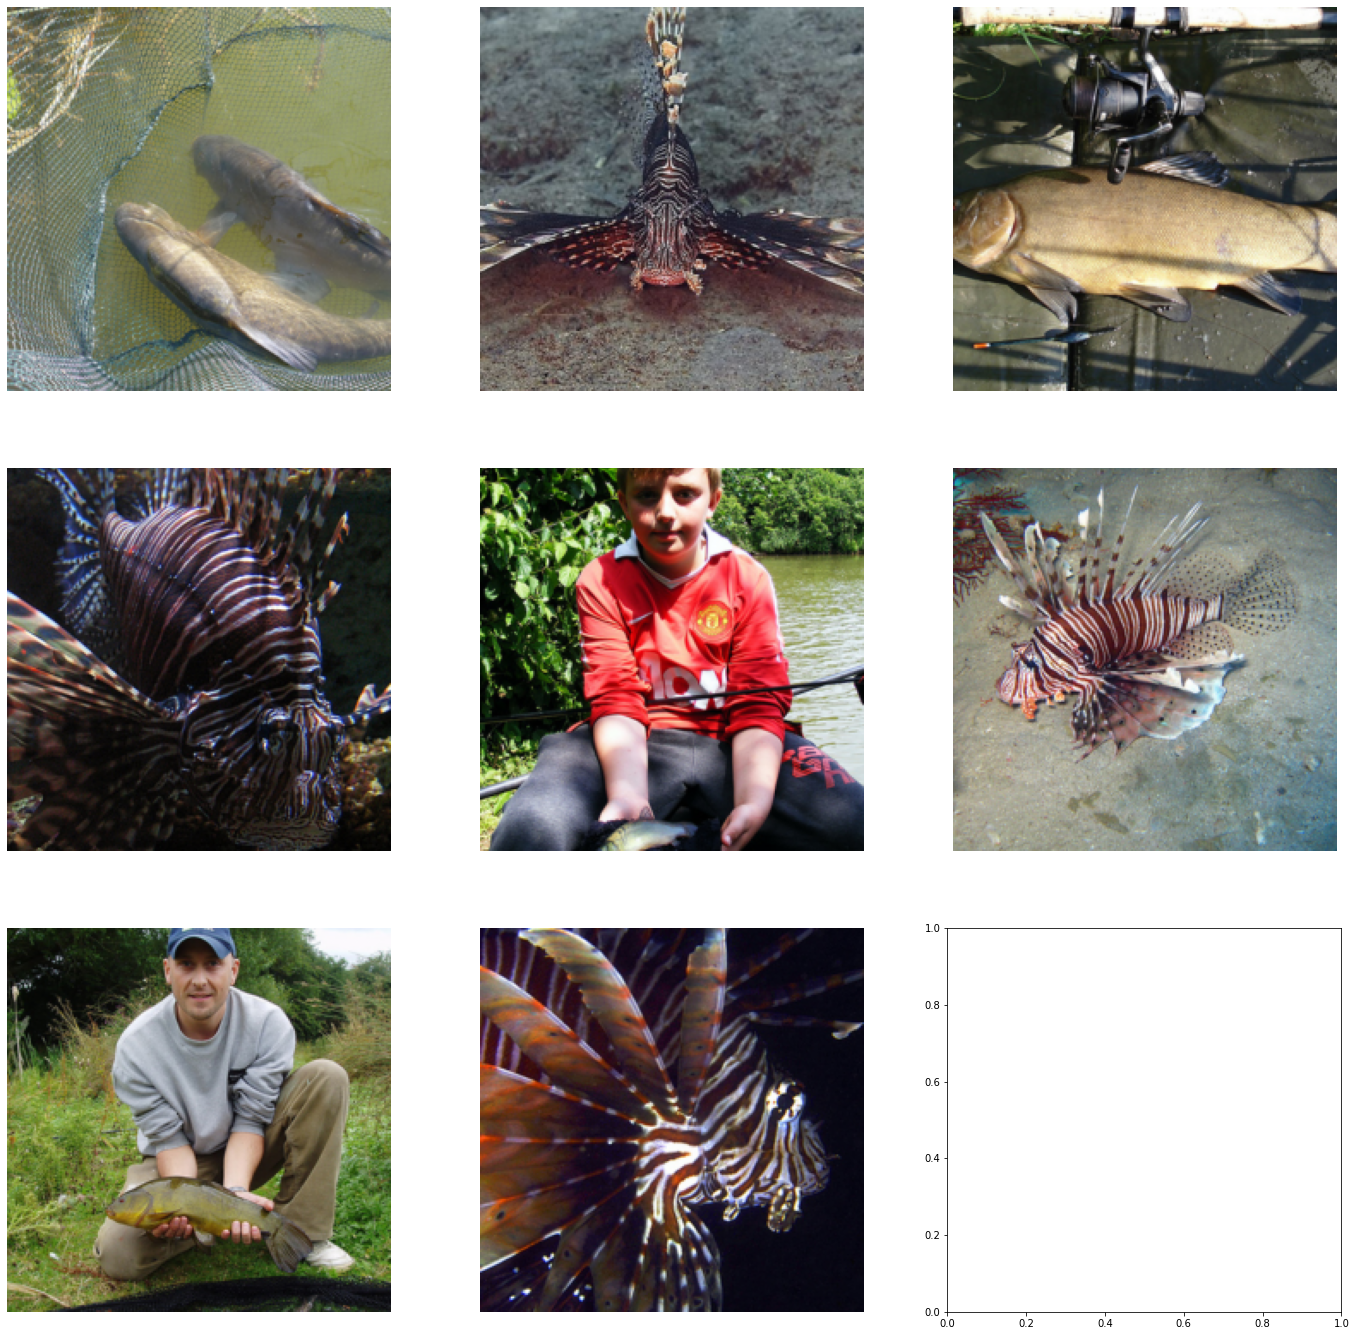

In [8]:
user.plot(true_user_data)

### Reconstruct user data:

In [9]:
target_idx = np.where(t_labels == cls_to_obtain)[0]
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = len(target_idx)
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][target_idx]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][target_idx]
tmp_true_user_data['labels'] = true_user_data['labels'][target_idx]

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.1283 |  Task loss: 928.9757 | T: 0.27s
| It: 1001 | Rec. loss: 0.1499 |  Task loss: 723.8113 | T: 82.96s
| It: 2001 | Rec. loss: 0.1240 |  Task loss: 735.9199 | T: 79.88s
| It: 3001 | Rec. loss: 0.1195 |  Task loss: 731.4233 | T: 81.56s
| It: 4001 | Rec. loss: 0.1184 |  Task loss: 721.1783 | T: 83.05s
| It: 5001 | Rec. loss: 0.1156 |  Task loss: 718.4772 | T: 82.98s
| It: 6001 | Rec. loss: 0.1309 |  Task loss: 706.1227 | T: 84.04s
| It: 7001 | Rec. loss: 0.1127 |  Task loss: 703.3412 | T: 83.98s
| It: 8001 | Rec. loss: 0.0981 |  Task loss: 730.0681 | T: 83.59s
| It: 9001 | Rec. loss: 0.1184 |  Task loss: 700.5631 | T: 82.88s
| It: 10001 | Rec. loss: 0.1167 |  Task loss: 698.8948 | T: 83.57s
| It: 11001 | Rec. loss: 0.1189 |  Task loss: 677.9911 | T: 83.79s
| It: 12001 | Rec. loss: 0.1152 |  Task loss: 691.6855 | T: 82.59s
| It: 13001 | Rec. loss: 0.1151 |  Task loss: 704.9163 | T: 84.27s
| It: 14001 | Rec. loss: 0.1096 |  Task loss: 720.3738 | T: 83.74s
| It: 150

In [11]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0441 | PSNR: 14.10 | FMSE: 9.1106e+02 | LPIPS: 0.51|
 R-PSNR: 14.29 | IIP-pixel: 62.50% | SSIM: 0.3281 | max R-PSNR: 17.23 | max SSIM: 0.4036 | Label Acc: 100.00%


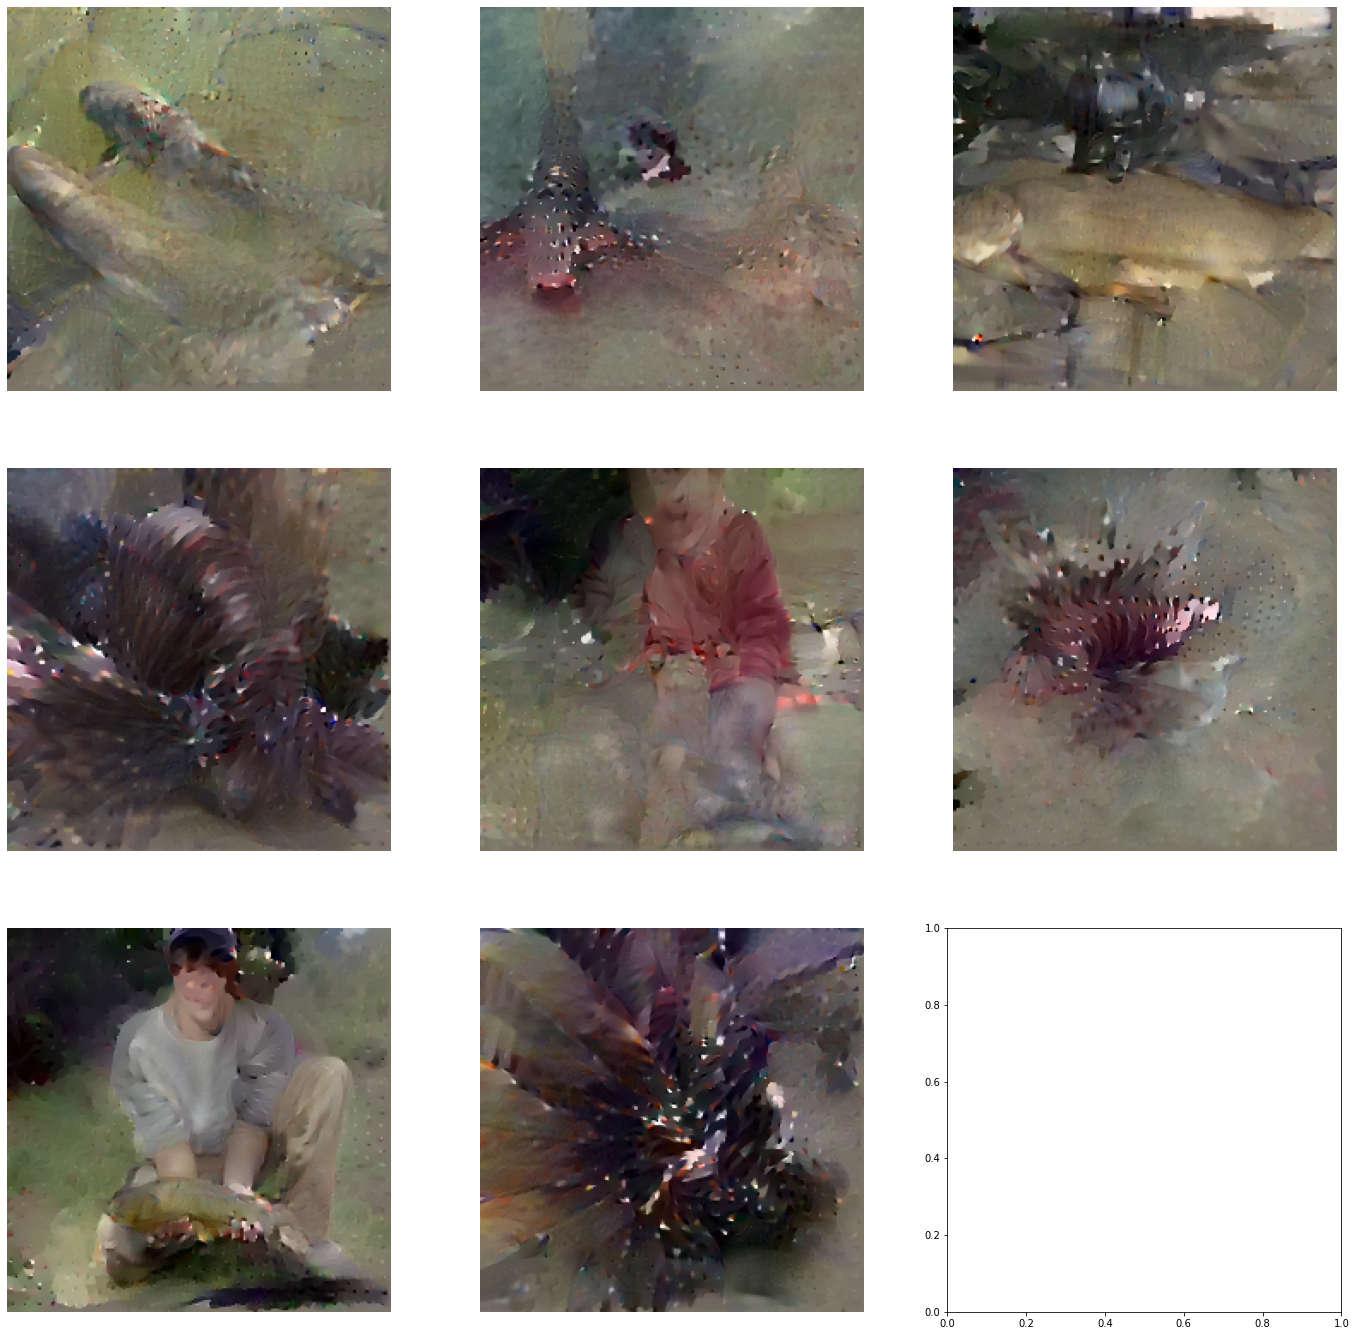

In [12]:
user.plot(reconstructed_user_data)